## Ghost Writer Training Test

In [1]:
import pandas as pd
import numpy as np
import ast
import re

In [2]:
hip = pd.read_csv('hiphop_corpus_with_lyrics.csv')

## Data PreProcessing

Since writers is currently stored as a string gonna convert to list

In [3]:
hip['writers'] = hip['writers'].apply(ast.literal_eval)

Break up lyrics by Verse

In [4]:
def clean_lyrics(lyrics):
    #Breaking up lyrics by verse
    verses = re.split(r'\[.*?\]', lyrics)
    #Cleaning up extra whitespace
    verses = [re.sub(r'\s+', ' ', verse).strip() for verse in verses if verse.strip()]
    return verses

In [5]:
hip['cleaned_lyrics'] = hip['lyrics'].apply(clean_lyrics)
hip.head()

,artist,album,song_title,date,writers,lyrics,title_clean,cleaned_lyrics
0,Mac Miller,Circles,Circles,"January 17, 2020",[Mac Miller],"[Verse 1]\nWell, this is what it look like rig...",circles,"[Well, this is what it look like right before ..."
1,Mac Miller,Circles,Complicated,"January 17, 2020","[Mac Miller, Jon Brion]","[Verse 1]\nOutside is cloudy, but I like that ...",complicated,"[Outside is cloudy, but I like that better (Be..."
2,Mac Miller,Circles,Blue World,"January 17, 2020","[Mac Miller, Guy Lawrence, Robert Craig Wright...",[Intro: The Four Freshman]\nIt's a blue world ...,blue world,[It's a blue world without you It's a blue wor...
3,Mac Miller,Circles,Good News,"January 9, 2020","[Mac Miller, Jon Brion]",[Verse 1]\nI spent the whole day in my head\nD...,good news,[I spent the whole day in my head Do a little ...
4,Mac Miller,Circles,I Can See,"January 17, 2020","[Mac Miller, Shea Taylor]","[Verse 1]\nI'm so close, I can taste it\nThe m...",i can see,"[I'm so close, I can taste it The man on the m..."


Will make sense later, but this song Drake doesn't speak once and is fully Kendrick speaking. Makes for sense for it to be added to Kendricks training data instead 

In [6]:
hip.loc[316,'artist'] = 'Kendrick Lamar'

Getting lyrics that was written by the artist. First will get who sang the verse and will then keep only the verses they were a part of

In [7]:
# Fixed version with hyphen normalization
def normalize_artist_name(name):
    """
    Normalize artist name by:
    - Converting to lowercase
    - Removing hyphens and converting to spaces
    - Trimming whitespace
    This makes "Jay-Z", "Jay Z", and "jay-z" all equivalent
    """
    return re.sub(r'[-_]+', ' ', name.lower().strip())

In [8]:
def get_main_artist_verses(lyrics, main_artist, writers, corpus_artists):
    
    # Normalize everything to lowercase
    main_artist = normalize_artist_name(main_artist)
    corpus_artists = [normalize_artist_name(c) for c in corpus_artists]
    writers = [normalize_artist_name(w) for w in writers]

    # Determine artists we explicitly want to EXCLUDE
    not_allowed_artists = [w for w in writers if w in corpus_artists and w != main_artist]

    # Split lyrics into [Header][Text]
    blocks = re.split(r'(\[[^\]]+\])', lyrics)
    verses = []

    for i in range(1, len(blocks), 2):
        header = blocks[i]
        text = blocks[i + 1] if i + 1 < len(blocks) else ""

        # Extract performing artists from header
        match = re.search(r'\[(?:[^\]:]*?:\s*)([^\]]+)\]', header)
        if match:
            artists = [a.strip().lower() for a in re.split(r'\s*(?:&|and)\s*', match.group(1))]
        else:
            artists = [main_artist]
        # ✅ Keep only if none of the performers are "not allowed"
        if any(a not in not_allowed_artists for a in artists):
            verses.append(text.strip())

    return verses



In [9]:
all_artists = hip['artist'].unique().tolist()

hip['main_artist_lyrics'] = hip.apply(
    lambda row: get_main_artist_verses(row['lyrics'], row['artist'], row['writers'], all_artists),
    axis=1
)

# Join the verses back into a single string per song
hip['main_artist_lyrics_joined'] = hip['main_artist_lyrics'].apply(lambda x: "\n".join(x))

hip.head()

,artist,album,song_title,date,writers,lyrics,title_clean,cleaned_lyrics,main_artist_lyrics,main_artist_lyrics_joined
0,Mac Miller,Circles,Circles,"January 17, 2020",[Mac Miller],"[Verse 1]\nWell, this is what it look like rig...",circles,"[Well, this is what it look like right before ...","[Well, this is what it look like right before ...","Well, this is what it look like right before y..."
1,Mac Miller,Circles,Complicated,"January 17, 2020","[Mac Miller, Jon Brion]","[Verse 1]\nOutside is cloudy, but I like that ...",complicated,"[Outside is cloudy, but I like that better (Be...","[Outside is cloudy, but I like that better (Be...","Outside is cloudy, but I like that better (Bet..."
2,Mac Miller,Circles,Blue World,"January 17, 2020","[Mac Miller, Guy Lawrence, Robert Craig Wright...",[Intro: The Four Freshman]\nIt's a blue world ...,blue world,[It's a blue world without you It's a blue wor...,[It's a blue world without you\nIt's a blue wo...,It's a blue world without you\nIt's a blue wor...
3,Mac Miller,Circles,Good News,"January 9, 2020","[Mac Miller, Jon Brion]",[Verse 1]\nI spent the whole day in my head\nD...,good news,[I spent the whole day in my head Do a little ...,[I spent the whole day in my head\nDo a little...,I spent the whole day in my head\nDo a little ...
4,Mac Miller,Circles,I Can See,"January 17, 2020","[Mac Miller, Shea Taylor]","[Verse 1]\nI'm so close, I can taste it\nThe m...",i can see,"[I'm so close, I can taste it The man on the m...","[I'm so close, I can taste it\nThe man on the ...","I'm so close, I can taste it\nThe man on the m..."


In [10]:
group_members = {
    "A Tribe Called Quest": ["Q-Tip", "Phife Dawg", "Ali Shaheed Muhammad"]
}

def flag_missing_header_artists(lyrics, main_artist, writers, corpus_artists, group_members=None):
    """
    Returns 1 if the lyric header does NOT include the main artist,
    and also does NOT include any other contributing artists from our corpus.
    """
    # Determine allowed names for the main artist
    allowed_artists = group_members.get(main_artist, [main_artist]) if group_members else [main_artist]
    allowed_artists = [a.lower() for a in allowed_artists]
    
    # Get all lyric headers in the song
    headers = re.findall(r'\[(?:[^\]:]*?:\s*)([^\]]+)\]', lyrics)
    
    # Split header artists by & / and, flatten all headers
    header_artists = []
    for h in headers:
        header_artists.extend([a.strip().lower() for a in re.split(r'\s*(?:&|and)\s*', h)])
    
    # Check if main artist is in any header
    main_in_header = any(a in allowed_artists for a in header_artists)
    
    # Get all other contributing artists from writers who are in our corpus
    other_contributors = [w for w in writers if w in corpus_artists and w != main_artist]
    
    # Check if any of these contributors appear in the headers
    contributor_in_header = any(a in other_contributors for a in header_artists)
    
    # Flag = 1 if main artist not in header and none of the other contributors are in header
    if not main_in_header and not contributor_in_header and len(other_contributors) > 0:
        return 1, other_contributors
    return 0, None


In [11]:
hip[['pot_ghost', 'pot_ghost_name']] = hip.apply(
    lambda row: pd.Series(flag_missing_header_artists(
        row['lyrics'],
        row['artist'],
        row['writers'],
        all_artists,
        group_members
    )),
    axis=1
)
hip.head()

,artist,album,song_title,date,writers,lyrics,title_clean,cleaned_lyrics,main_artist_lyrics,main_artist_lyrics_joined,pot_ghost,pot_ghost_name
0,Mac Miller,Circles,Circles,"January 17, 2020",[Mac Miller],"[Verse 1]\nWell, this is what it look like rig...",circles,"[Well, this is what it look like right before ...","[Well, this is what it look like right before ...","Well, this is what it look like right before y...",0.0,NaN
1,Mac Miller,Circles,Complicated,"January 17, 2020","[Mac Miller, Jon Brion]","[Verse 1]\nOutside is cloudy, but I like that ...",complicated,"[Outside is cloudy, but I like that better (Be...","[Outside is cloudy, but I like that better (Be...","Outside is cloudy, but I like that better (Bet...",0.0,NaN
2,Mac Miller,Circles,Blue World,"January 17, 2020","[Mac Miller, Guy Lawrence, Robert Craig Wright...",[Intro: The Four Freshman]\nIt's a blue world ...,blue world,[It's a blue world without you It's a blue wor...,[It's a blue world without you\nIt's a blue wo...,It's a blue world without you\nIt's a blue wor...,0.0,NaN
3,Mac Miller,Circles,Good News,"January 9, 2020","[Mac Miller, Jon Brion]",[Verse 1]\nI spent the whole day in my head\nD...,good news,[I spent the whole day in my head Do a little ...,[I spent the whole day in my head\nDo a little...,I spent the whole day in my head\nDo a little ...,0.0,NaN
4,Mac Miller,Circles,I Can See,"January 17, 2020","[Mac Miller, Shea Taylor]","[Verse 1]\nI'm so close, I can taste it\nThe m...",i can see,"[I'm so close, I can taste it The man on the m...","[I'm so close, I can taste it\nThe man on the ...","I'm so close, I can taste it\nThe man on the m...",0.0,NaN


In [210]:
hip[hip['artist']=='Mac Miller']

,artist,album,song_title,date,writers,lyrics,title_clean,cleaned_lyrics,main_artist_lyrics,main_artist_lyrics_joined,pot_ghost,pot_ghost_name
0,Mac Miller,Circles,Circles,"January 17, 2020",[Mac Miller],"[Verse 1]\nWell, this is what it look like rig...",circles,"[Well, this is what it look like right before ...","[Well, this is what it look like right before ...","Well, this is what it look like right before y...",0.0,NaN
1,Mac Miller,Circles,Complicated,"January 17, 2020","[Mac Miller, Jon Brion]","[Verse 1]\nOutside is cloudy, but I like that ...",complicated,"[Outside is cloudy, but I like that better (Be...","[Outside is cloudy, but I like that better (Be...","Outside is cloudy, but I like that better (Bet...",0.0,NaN
2,Mac Miller,Circles,Blue World,"January 17, 2020","[Mac Miller, Guy Lawrence, Robert Craig Wright...",[Intro: The Four Freshman]\nIt's a blue world ...,blue world,[It's a blue world without you It's a blue wor...,[It's a blue world without you\nIt's a blue wo...,It's a blue world without you\nIt's a blue wor...,0.0,NaN
3,Mac Miller,Circles,Good News,"January 9, 2020","[Mac Miller, Jon Brion]",[Verse 1]\nI spent the whole day in my head\nD...,good news,[I spent the whole day in my head Do a little ...,[I spent the whole day in my head\nDo a little...,I spent the whole day in my head\nDo a little ...,0.0,NaN
4,Mac Miller,Circles,I Can See,"January 17, 2020","[Mac Miller, Shea Taylor]","[Verse 1]\nI'm so close, I can taste it\nThe m...",i can see,"[I'm so close, I can taste it The man on the m...","[I'm so close, I can taste it\nThe man on the ...","I'm so close, I can taste it\nThe man on the m...",0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1160,Mac Miller,Watching Movies with the Sound Off (10th Anniv...,Someone Like You,"June 18, 2013","[Mac Miller, J. Hill, E. Dan, Big Jerm, Sayez,...","[Sample: Nylo]\nSomeone like, someone like\nSo...",someone like you,"[Someone like, someone like Someone like, some...","[Someone like, someone like\nSomeone like, som...","Someone like, someone like\nSomeone like, some...",0.0,NaN
1161,Mac Miller,Watching Movies with the Sound Off (10th Anniv...,Watching Movies,"May 9, 2013","[Mac Miller, Sap, Greg Mauro]","[Intro]\nYo, all your bitches got the green bo...",watching movies,"[Yo, all your bitches got the green boat Yeah,...","[Yo, all your bitches got the green boat\nYeah...","Yo, all your bitches got the green boat\nYeah\...",0.0,NaN
1162,Mac Miller,Macadelic,Thoughts from a Balcony,"March 23, 2012","[Mac Miller, Sap, Richard Pike, Neal Sutherlan...",[Intro]\nIt was all about a dream\nTurned into...,thoughts from a balcony,"[It was all about a dream Turned into reality,...",[It was all about a dream\nTurned into reality...,"It was all about a dream\nTurned into reality,...",0.0,NaN
1163,Mac Miller,"I Love Life, Thank You",Love Lost,"May 19, 2011",[Mac Miller],"[Intro]\n(Our love was lost)\nHey, hey, haha (...",love lost,"[(Our love was lost) Hey, hey, haha (Where'd y...","[(Our love was lost)\nHey, hey, haha (Where'd ...","(Our love was lost)\nHey, hey, haha (Where'd y...",0.0,NaN


In [12]:
hip[hip['pot_ghost'] == 1]

,artist,album,song_title,date,writers,lyrics,title_clean,cleaned_lyrics,main_artist_lyrics,main_artist_lyrics_joined,pot_ghost,pot_ghost_name
13,Mac Miller,Swimming,Hurt Feelings,"August 3, 2018","[Mac Miller, J. Cole, Jon Brion, Devonté Hynes...",[Intro]\nYeah\nWoah-woah-woah-woah-woah-woah-w...,hurt feelings,[Yeah Woah-woah-woah-woah-woah-woah-woah-woah ...,[Yeah\nWoah-woah-woah-woah-woah-woah-woah-woah...,Yeah\nWoah-woah-woah-woah-woah-woah-woah-woah ...,1.0,[J. Cole]
397,J. Cole,Cole World: The Sideline Story,Work Out,"June 15, 2011","[Elliot Wolff, John Legend, Miri Ben-Ari - מיר...","[Intro]\nI want to see you work out for me, wo...",work out,"[I want to see you work out for me, work out f...","[I want to see you work out for me, work out f...","I want to see you work out for me, work out fo...",1.0,[Kanye West]
531,Kanye West,The Life of Pablo,Facts (Charlie Heat Version),"December 31, 2015","[Kanye West, Charlie Heat, Metro Boomin, South...",[Intro]\nDirt and grime and filth inside\nThe ...,facts,[Dirt and grime and filth inside The story of ...,[Dirt and grime and filth inside\nThe story of...,Dirt and grime and filth inside\nThe story of ...,1.0,[Drake]
743,Jay-Z,Watch the Throne,Murder to Excellence,"August 8, 2011","[JAY-Z, Kanye West, Swizz Beatz, Mihaela Modor...",[Produced by S1 and Swizz Beatz]\n\n[Part I: M...,murder to excellence,"[Uh, bloody murder, murder, murder Bloody murd...","[, , Uh, bloody murder, murder, murder\nBloody...","\n\nUh, bloody murder, murder, murder\nBloody ...",1.0,[Kanye West]
746,Jay-Z,Watch the Throne,Illest Motherfucker Alive,"August 8, 2011","[JAY-Z, Kanye West, MIKE DEAN, Southside, Kid ...",[Three minutes of silence]\n\n[Intro: Kanye We...,illest motherfucker alive,"[Uh-oh, damn, uh-oh 1985 white Lamborghini Cou...","[, Take it how you want 'til a nigga dead\n'Ti...",\nTake it how you want 'til a nigga dead\n'Til...,1.0,[Kanye West]
748,Jay-Z,Watch the Throne,Primetime,"August 8, 2011","[JAY-Z, Kanye West, No I.D., Maureen Reid, Lar...",[Produced by No I.D.]\n\n[Intro: Jay Z]\nWe in...,primetime,"[We in the time of our lives, baby Turn the mu...","[, We in the time of our lives, baby\nTurn the...","\nWe in the time of our lives, baby\nTurn the ...",1.0,[Kanye West]
751,Jay-Z,The Blueprint 3,Thank You,"September 8, 2009","[JAY-Z, Kanye West, No I.D., Marcos Valle]","[Intro]\nThank you, thank you very much for co...",thank you,"[Thank you, thank you very much for coming out...","[Thank you, thank you very much for coming out...","Thank you, thank you very much for coming out ...",1.0,[Kanye West]
768,Jay-Z,The Black Album,Encore,"November 14, 2003","[JAY-Z, Kanye West, Lennon-McCartney, John Len...",[Produced by Kanye West]\n\n[Intro]\nThank you...,encore,"[Thank you, thank you, thank you! You're far t...","[, Thank you, thank you, thank you!\nYou're fa...","\nThank you, thank you, thank you!\nYou're far...",1.0,[Kanye West]
776,Jay-Z,The Black Album,Lucifer,"November 14, 2003","[JAY-Z, Kanye West, Mamie Smith, Oliver Hugh P...",[Produced by Kanye West]\n\n[Intro]\nKanyeezy ...,lucifer,"[Kanyeezy you did it again, you a genius, nigg...","[, Kanyeezy you did it again, you a genius, ni...","\nKanyeezy you did it again, you a genius, nig...",1.0,[Kanye West]
780,Jay-Z,The Blueprint,Takeover,"September 11, 2001","[JAY-Z, Kanye West, Jim Morrison, John Densmor...","[Intro]\nC'mon\nWoo\n\n[Chorus]\nR-O-C, we run...",takeover,"[C'mon Woo, R-O-C, we runnin' this rap shit Me...","[C'mon\nWoo, R-O-C, we runnin' this rap shit\n...","C'mon\nWoo\nR-O-C, we runnin' this rap shit\nM...",1.0,[Kanye West]


In [13]:
test_data = hip[hip['pot_ghost'] == 1]
train_data = hip[hip['pot_ghost'] == 0]

## Trying word embedding 

In [14]:
import torch
import random
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score

In [20]:
artist_mapping = {artist: idx for idx, artist in enumerate(all_artists)}

train_data['artist_id'] = train_data['artist'].map(artist_mapping)
train_data = train_data.loc[:,['main_artist_lyrics_joined', 'artist_id']]

test_data['artist_id'] = test_data['artist'].map(artist_mapping)
test_data = test_data.loc[:,['main_artist_lyrics_joined', 'artist_id']]
#replacing the null "So Soon" row with the cleaned joined lyrics instead
#this song was released by kanye but helped written by quentin. would be good test case to see who'd it classify as
test_data.iloc[19,test_data.columns.get_loc('main_artist_lyrics_joined')] = "\n".join(hip['cleaned_lyrics'][1235])

train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['artist_id'])

/var/folders/g4/t1q9yqqx7h36p5_2jzq23jsw0000gn/T/ipykernel_49986/2084513134.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['artist_id'] = train_data['artist'].map(artist_mapping)
/var/folders/g4/t1q9yqqx7h36p5_2jzq23jsw0000gn/T/ipykernel_49986/2084513134.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['artist_id'] = test_data['artist'].map(artist_mapping)


## Set up tokenizing lyrics

In [66]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [15]:
class MultiClassRegression(nn.Module):
    def __init__(self, dim, num_classes):
        super(MultiClassRegression, self).__init__()
        self.layer1 = nn.Linear(dim, 128)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        probs = self.layer1(x)
        probs = self.relu(probs)
        probs = self.layer2(probs)
        return probs

In [73]:
def dataset_to_bert(texts, labels):
    encoded = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors='pt'
    )
    return torch.utils.data.TensorDataset(
        encoded['input_ids'],
        encoded['attention_mask'],
        torch.tensor(labels, dtype=torch.long)
    )

train_dataset = dataset_to_bert(train_data['main_artist_lyrics_joined'].tolist(),
                             train_data['artist_id'].values)
val_dataset = dataset_to_bert(val_data['main_artist_lyrics_joined'].tolist(),
                           val_data['artist_id'].values)


In [74]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [81]:
random.seed(1234)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)
model = MultiClassRegression(bert_model.config.hidden_size, len(artist_mapping)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-4)

num_epochs = 50

acc_list = []

for epoch in range(num_epochs):
    model.train()
    for input_ids, attention_mask, labels in train_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        with torch.no_grad():  # freeze BERT for now
            bert_out = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = bert_out.pooler_output  # [batch_size, 768]
        
        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # --- validation ---
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for input_ids, attention_mask, labels in val_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            bert_out = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = bert_out.pooler_output
            outputs = model(embeddings)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    acc = accuracy_score(all_labels, all_preds)
    acc_list.append(acc)
    print(f"Epoch {epoch+1}, Validation Accuracy: {acc:.4f}")


Epoch 1, Validation Accuracy: 0.1168
Epoch 2, Validation Accuracy: 0.1168
Epoch 3, Validation Accuracy: 0.1311
Epoch 4, Validation Accuracy: 0.1339
Epoch 5, Validation Accuracy: 0.1254
Epoch 6, Validation Accuracy: 0.1453
Epoch 7, Validation Accuracy: 0.1567
Epoch 8, Validation Accuracy: 0.1510
Epoch 9, Validation Accuracy: 0.1595
Epoch 10, Validation Accuracy: 0.1766
Epoch 11, Validation Accuracy: 0.1966
Epoch 12, Validation Accuracy: 0.1652
Epoch 13, Validation Accuracy: 0.2023
Epoch 14, Validation Accuracy: 0.1823
Epoch 15, Validation Accuracy: 0.1880
Epoch 16, Validation Accuracy: 0.2137
Epoch 17, Validation Accuracy: 0.2365
Epoch 18, Validation Accuracy: 0.2080
Epoch 19, Validation Accuracy: 0.2108
Epoch 20, Validation Accuracy: 0.2336
Epoch 21, Validation Accuracy: 0.2051
Epoch 22, Validation Accuracy: 0.2336
Epoch 23, Validation Accuracy: 0.2137
Epoch 24, Validation Accuracy: 0.2393
Epoch 25, Validation Accuracy: 0.2308
Epoch 26, Validation Accuracy: 0.2450
Epoch 27, Validation 

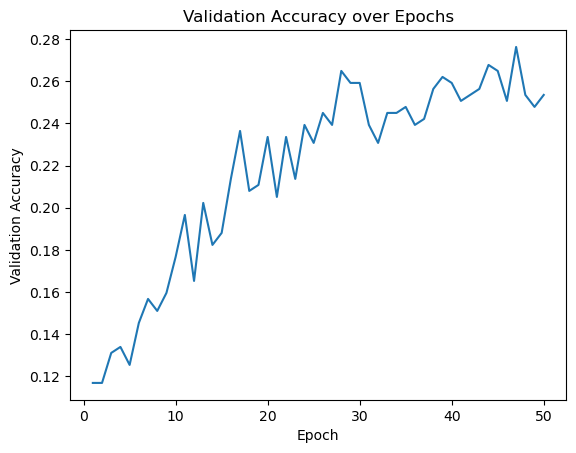

In [82]:
from matplotlib import pyplot as plt
plt.plot(range(1, num_epochs + 1), acc_list)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.show()

In [ ]:
classification_report(all_labels, all_preds, target_names=[artist for artist, idx in sorted(artist_mapping.items(), key=lambda x: x[1])])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


'                      precision    recall  f1-score   support\n\n          Mac Miller       0.28      0.37      0.32        27\n      Kendrick Lamar       0.33      0.04      0.07        26\n      Quentin Miller       0.00      0.00      0.00        22\n               Drake       0.26      0.36      0.30        39\n             J. Cole       0.11      0.03      0.05        30\nA Tribe Called Quest       0.00      0.00      0.00        20\n          Kanye West       0.31      0.40      0.35        30\n          Soulja Boy       0.47      0.76      0.58        29\n               Jay-Z       0.09      0.12      0.10        26\n               Big L       0.60      0.14      0.22        22\n  Tyler, The Creator       0.29      0.08      0.12        26\n                2Pac       0.18      0.35      0.24        26\n         Joey Bada$$       0.17      0.43      0.25        28\n\n            accuracy                           0.25       351\n           macro avg       0.24      0.24      0.2

In [ ]:
test_dataset = dataset_to_bert(test_data['main_artist_lyrics_joined'].tolist(),
                           test_data['artist_id'].values)

yhats = []

embeddings_list = []

input_ids = [test_dataset[i][0] for i in range(len(test_dataset))]
attention_mask = [test_dataset[i][1] for i in range(len(test_dataset))]

for input_id, attention_m in zip(input_ids, attention_mask):
    input_id = input_id.unsqueeze(0).to(device)
    attention_m = attention_m.unsqueeze(0).to(device)
    bert_out = bert_model(input_ids=input_id, attention_mask=attention_m)
    embeddings = bert_out.pooler_output
    embeddings_list.append(embeddings)
    
    outputs = model(embeddings)
    preds = outputs.argmax(dim=1)

    yhats.extend(preds)

In [116]:
pred_art_lab = [list(artist_mapping.keys())[list(artist_mapping.values()).index(yhat.item())] for yhat in yhats]
act_art_lab = [list(artist_mapping.keys())[list(artist_mapping.values()).index(art_id)] for art_id in test_data['artist_id']]
test_data['act_artist'] = act_art_lab
test_data['pot_ghost_name'] = hip[hip['pot_ghost'] == 1]['pot_ghost_name'].values
test_data['predicted_artist'] = pred_art_lab

test_data

,main_artist_lyrics_joined,artist_id,act_artist,pot_ghost_name,predicted_artist
13,Yeah\nWoah-woah-woah-woah-woah-woah-woah-woah ...,0,Mac Miller,[J. Cole],Jay-Z
397,"I want to see you work out for me, work out fo...",4,J. Cole,[Kanye West],Drake
531,Dirt and grime and filth inside\nThe story of ...,6,Kanye West,[Drake],Kanye West
743,"\n\nUh, bloody murder, murder, murder\nBloody ...",8,Jay-Z,[Kanye West],2Pac
746,\nTake it how you want 'til a nigga dead\n'Til...,8,Jay-Z,[Kanye West],Joey Bada$$
748,"\nWe in the time of our lives, baby\nTurn the ...",8,Jay-Z,[Kanye West],Joey Bada$$
751,"Thank you, thank you very much for coming out ...",8,Jay-Z,[Kanye West],Joey Bada$$
768,"\nThank you, thank you, thank you!\nYou're far...",8,Jay-Z,[Kanye West],Joey Bada$$
776,"\nKanyeezy you did it again, you a genius, nig...",8,Jay-Z,[Kanye West],2Pac
780,"C'mon\nWoo\nR-O-C, we runnin' this rap shit\nM...",8,Jay-Z,[Kanye West],2Pac


In [ ]:
model_state_dict = model.state_dict()
PATH = "model_parameters.pth"
torch.save(model_state_dict, PATH)

## Bag of Words

Trying Bag of Words as simpler approach

Creating our BOW dictionary

In [16]:
def tokenize(string):
    wo_spec_char = re.sub(r'[^a-zA-Z0-9\s]','',string.lower())
    cleaned_tokens = re.split(r'\s',wo_spec_char)
    return cleaned_tokens

In [21]:
from collections import Counter
from scipy.sparse import csr_matrix

lyrics = train_data['main_artist_lyrics_joined']
for id, lyric in enumerate(lyrics):
    tokens = tokenize(lyric)
    
    if id == 0:
        bag_of_words = Counter(tokens)
        
    bag_of_words.update(tokens)
    
del bag_of_words['']
len(bag_of_words)

28593

Removing articles from the bag of words to hopefully learn from more meanigful words

In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(
    lowercase=True,
    max_features=50000,     # recommended cap
    ngram_range=(1, 2)      # big improvement for lyrics
)

Creating a sparse matrix to then use this to train what words each artist is using

In [18]:
def sparse(input_data):
    gen_tokenized = [tokenize(lyric) for index, lyric in enumerate(input_data)]

    col_ind = []
    row_ind = []
    data = []
    vocabulary = {term: idx for idx, term in enumerate(bag_of_words.keys())}

    i = 0

    for g in gen_tokenized:
        for term in g:
            if term in vocabulary:
                index = vocabulary[term]
                col_ind.append(index)
                data.append(1)
                row_ind.append(i)
        i += 1

    sparse_mat = csr_matrix((data, (row_ind, col_ind)),shape = (len(input_data),len(vocabulary)), dtype=int).toarray()
    
    return sparse_mat, col_ind, row_ind, data

In [22]:
sparse_train = sparse(lyrics)
sparse_val = sparse(val_data['main_artist_lyrics_joined'])

In [23]:
def to_sparse_torch(row_ind, col_ind, data, input_data):
    i = torch.tensor([row_ind,col_ind], dtype = torch.long)
    d = torch.tensor(data)
    vocabulary = {term: idx for idx, term in enumerate(bag_of_words.keys())}
    return torch.sparse_coo_tensor(i,d,size = (len(input_data),len(vocabulary)), dtype = torch.float32)

In [ ]:
#x_train = to_sparse_torch(sparse_train[2],sparse_train[1],sparse_train[3],train_data)
X_train = tfidf.fit_transform(train_data['main_artist_lyrics_joined'])
x_train = torch.sparse_csr_tensor(
    X_train.indptr,
    X_train.indices,
    X_train.data,
    size=X_train.shape,
    dtype=torch.float32
)
y_train = torch.tensor(train_data['artist_id'].values, dtype = torch.long)

#x_val = to_sparse_torch(sparse_val[2],sparse_val[1],sparse_val[3],val_data)
X_val = tfidf.transform(val_data['main_artist_lyrics_joined'])
x_val = torch.sparse_csr_tensor(
    X_val.indptr,
    X_val.indices,
    X_val.data,
    size=X_val.shape,
    dtype=torch.float32
)
y_val = torch.tensor(val_data['artist_id'].values,dtype=torch.long)

sgd_model = MultiClassRegression(x_train.shape[1], len(artist_mapping))

loss_fn = nn.CrossEntropyLoss()
optim_sgd = AdamW(sgd_model.parameters(), lr=1e-4)
num_epoch = 50

val_loss = []

random.seed(123)

for epoch in range(num_epoch):
    model.train()
    for step in range(len(train_data)):
        index = np.random.randint(0,len(train_data))
        x_batch = x_train[index].unsqueeze(0)
    
        predicted = sgd_model(x_batch)
        loss_sgd = loss_fn(predicted,y_train[index].unsqueeze(0))
        
        optim_sgd.zero_grad()
        loss_sgd.backward()
        optim_sgd.step()
        
    
    print(f'epoch:{epoch+1}, loss:{loss.item()}')

    sgd_model.eval()

    with torch.no_grad():
        predicted_val = sgd_model(x_val)
        
        pred_label=torch.argmax(predicted_val,dim=1)
        
        loss_val = loss_fn(predicted_val,y_val)
        val_loss.append(loss_val.item())
    
        val_acc = accuracy_score(y_val,pred_label)
        print(f'epoch:{epoch+1}, val_loss:{loss_val.item()}, val_acc:{val_acc}')


/var/folders/g4/t1q9yqqx7h36p5_2jzq23jsw0000gn/T/ipykernel_49986/861878355.py:3: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_7918qdo__j/croot/libtorch_1744403106694/work/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  x_train = torch.sparse_csr_tensor(


epoch:1, loss:2.559157371520996
epoch:1, val_loss:2.5013070106506348, val_acc:0.16809116809116809
epoch:2, loss:2.4165518283843994
epoch:2, val_loss:2.381683349609375, val_acc:0.19658119658119658
epoch:3, loss:1.5658652782440186
epoch:3, val_loss:2.2404210567474365, val_acc:0.29914529914529914
epoch:4, loss:1.8262813091278076
epoch:4, val_loss:2.0766475200653076, val_acc:0.4472934472934473
epoch:5, loss:1.141756534576416
epoch:5, val_loss:1.919353723526001, val_acc:0.5071225071225072
epoch:6, loss:0.48785945773124695
epoch:6, val_loss:1.7904936075210571, val_acc:0.5641025641025641
epoch:7, loss:0.24017947912216187
epoch:7, val_loss:1.6796085834503174, val_acc:0.6068376068376068
epoch:8, loss:0.15269362926483154
epoch:8, val_loss:1.592928409576416, val_acc:0.5897435897435898
epoch:9, loss:0.032092172652482986
epoch:9, val_loss:1.5225857496261597, val_acc:0.5982905982905983
epoch:10, loss:0.07553187012672424
epoch:10, val_loss:1.4613604545593262, val_acc:0.5982905982905983
epoch:11, loss

KeyboardInterrupt: 

In [158]:
#try with dataloader instead 

#x_train = to_sparse_torch(sparse_train[2],sparse_train[1],sparse_train[3],train_data)
X_train = tfidf.fit_transform(train_data['main_artist_lyrics_joined'])
x_train = torch.tensor(X_train.toarray(), dtype=torch.float32)
y_train = torch.tensor(train_data['artist_id'].values, dtype = torch.long)


X_val = tfidf.transform(val_data['main_artist_lyrics_joined'])
x_val   = torch.tensor(X_val.toarray(), dtype=torch.float32)
y_val = torch.tensor(val_data['artist_id'].values,dtype=torch.long)

model = MultiClassRegression(x_train.shape[1], len(artist_mapping))

loss_fn = nn.CrossEntropyLoss()
optim = AdamW(model.parameters(), lr=1e-4)
num_epoch = 5000

val_loss = []

random.seed(123)

for epoch in range(num_epoch):
    model.train()
    
    predicted = model(x_train)
    loss = loss_fn(predicted,y_train)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
        
    if epoch % 50 == 0:
        print(f'epoch:{epoch+1}, loss:{loss.item()}')

    model.eval()
    
    with torch.no_grad():
        predicted_val = model(x_val)
        
        pred_label = torch.argmax(predicted_val, dim=1)
        
        loss_val = loss_fn(predicted_val,y_val)
        val_loss.append(loss_val.item())
    
        val_acc = accuracy_score(y_val,pred_label)
        
        if epoch % 50 == 0:
            print(f'epoch:{epoch+1}, val_loss:{loss_val.item()}, val_acc:{val_acc}')


epoch:1, loss:2.5645689964294434
epoch:1, val_loss:2.564063549041748, val_acc:0.08262108262108261
epoch:51, loss:2.4365243911743164
epoch:51, val_loss:2.528096914291382, val_acc:0.2564102564102564
epoch:101, loss:2.260507583618164
epoch:101, val_loss:2.4815280437469482, val_acc:0.32193732193732194
epoch:151, loss:2.0426926612854004
epoch:151, val_loss:2.425292491912842, val_acc:0.3504273504273504
epoch:201, loss:1.7908005714416504
epoch:201, val_loss:2.361037254333496, val_acc:0.38461538461538464
epoch:251, loss:1.520296335220337
epoch:251, val_loss:2.2913355827331543, val_acc:0.4074074074074074
epoch:301, loss:1.251843810081482
epoch:301, val_loss:2.2193658351898193, val_acc:0.4415954415954416
epoch:351, loss:1.0062170028686523
epoch:351, val_loss:2.1486568450927734, val_acc:0.47863247863247865
epoch:401, loss:0.7980459928512573
epoch:401, val_loss:2.0824391841888428, val_acc:0.5042735042735043
epoch:451, loss:0.6323798894882202
epoch:451, val_loss:2.0228633880615234, val_acc:0.521367

Trying it on the potentially ghost written data now

In [159]:
#setting up data for model
test_sparse = sparse(test_data['main_artist_lyrics_joined']) 

#x_test = to_sparse_torch(test_sparse[2],test_sparse[1],test_sparse[3],test_data)
X_test = tfidf.transform(test_data['main_artist_lyrics_joined'])
x_test = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_test = torch.tensor(test_data['artist_id'].values, dtype = torch.long)

#getting the predicted labels
predicted = model(x_test)
test_label = []

for song in predicted:
    test_label.append(torch.argmax(song))
    
print(accuracy_score(test_label,y_test))

pred_art_lab = [list(artist_mapping.keys())[list(artist_mapping.values()).index(yhat.item())] for yhat in test_label]
act_art_lab = [list(artist_mapping.keys())[list(artist_mapping.values()).index(art_id)] for art_id in y_test.numpy()]

test_copy = test_data.copy()

test_copy['act_artist'] = act_art_lab
test_copy['pot_ghost_name'] = hip[hip['pot_ghost'] == 1]['pot_ghost_name'].values
test_copy['predicted_artist'] = pred_art_lab

test_copy

0.2894736842105263


,main_artist_lyrics_joined,artist_id,act_artist,pot_ghost_name,predicted_artist
13,Yeah\nWoah-woah-woah-woah-woah-woah-woah-woah ...,0,Mac Miller,[J. Cole],Mac Miller
397,"I want to see you work out for me, work out fo...",4,J. Cole,[Kanye West],Drake
531,Dirt and grime and filth inside\nThe story of ...,6,Kanye West,[Drake],Kanye West
743,"\n\nUh, bloody murder, murder, murder\nBloody ...",8,Jay-Z,[Kanye West],Jay-Z
746,\nTake it how you want 'til a nigga dead\n'Til...,8,Jay-Z,[Kanye West],Drake
748,"\nWe in the time of our lives, baby\nTurn the ...",8,Jay-Z,[Kanye West],Jay-Z
751,"Thank you, thank you very much for coming out ...",8,Jay-Z,[Kanye West],J. Cole
768,"\nThank you, thank you, thank you!\nYou're far...",8,Jay-Z,[Kanye West],Jay-Z
776,"\nKanyeezy you did it again, you a genius, nig...",8,Jay-Z,[Kanye West],Jay-Z
780,"C'mon\nWoo\nR-O-C, we runnin' this rap shit\nM...",8,Jay-Z,[Kanye West],Quentin Miller


In [161]:
W = model.layer2.weight.detach().cpu().numpy()   # shape: (num_artists, vocab_size)

vocab_list = list(bag_of_words.keys())           # same order as your sparse vectors

top_words_per_artist = {}

for artist, idx in artist_mapping.items():
    artist_weights = W[idx]
    top_idx = np.argsort(-artist_weights)[:20]    # top positive weights
    top_words = [vocab_list[i] for i in top_idx]
    top_words_per_artist[artist] = top_words

top_words_per_artist


{'Mac Miller': ['wonder',
  'water',
  'the',
  'wine',
  'thinking',
  'mmm',
  'so',
  'much',
  'time',
  'niggas',
  'wont',
  'now',
  'lip',
  'gone',
  'talking',
  'see',
  'way',
  'never',
  'jumpin',
  'heart'],
 'Kendrick Lamar': ['wonder',
  'wine',
  'water',
  'nothin',
  'much',
  'type',
  'caught',
  'even',
  'shot',
  'iii',
  'to',
  'harder',
  'too',
  'all',
  'puttin',
  'back',
  'yeah',
  'notice',
  'cant',
  'maneuver'],
 'Quentin Miller': ['time',
  'one',
  'thought',
  'see',
  'way',
  'water',
  'wont',
  'type',
  'back',
  'show',
  'what',
  'youd',
  'too',
  'brick',
  'keep',
  'click',
  'no',
  'fit',
  'maneuver',
  'sense'],
 'Drake': ['ugh',
  'myself',
  'fell',
  'yeah',
  'bout',
  'aint',
  'talking',
  'shot',
  'messing',
  'day',
  'digital',
  'through',
  'niggas',
  'maneuver',
  'name',
  'one',
  'could',
  'back',
  'thinking',
  'even'],
 'J. Cole': ['gotta',
  'one',
  'heard',
  'feel',
  'wonder',
  'find',
  'but',
  'show'

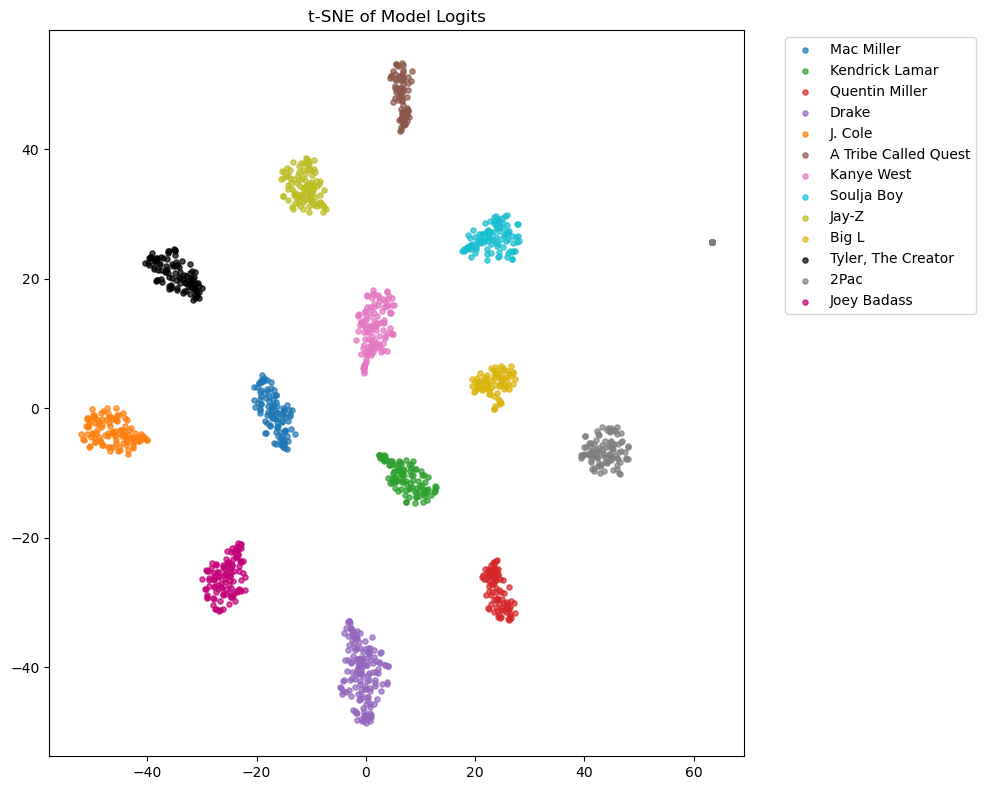

In [194]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# get logits for training data
with torch.no_grad():
    logits = model(x_train).cpu().numpy()

labels = train_data['artist_id'].values
id_to_name = {v: k for k, v in artist_mapping.items()}
id_to_name[12] = 'Joey Badass'

artist_id = list(id_to_name.keys())

colors = ['tab:blue',      # 0
    'tab:green',     # 1
    'tab:red',       # 2
    'tab:purple',    # 3
    'tab:orange',    # 4
    'tab:brown',     # 5
    'tab:pink',      # 6
    'tab:cyan',      # 7
    'tab:olive',     # 8
    'xkcd:gold',     # 9
    'black',      # 10
    'tab:gray',         # 11 <- for 2Pac
    'xkcd:magenta']  
emb = TSNE(n_components=2).fit_transform(logits)

plt.figure(figsize=(10,8))
for i, aid in enumerate(artist_id):
    idx = labels == aid
    plt.scatter(
        emb[idx, 0],
        emb[idx, 1],
        label=id_to_name[aid],
        s=14, alpha=0.7,
        color = colors[i]
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")  # move legend outside
plt.title("t-SNE of Model Logits")
plt.tight_layout()
plt.show()


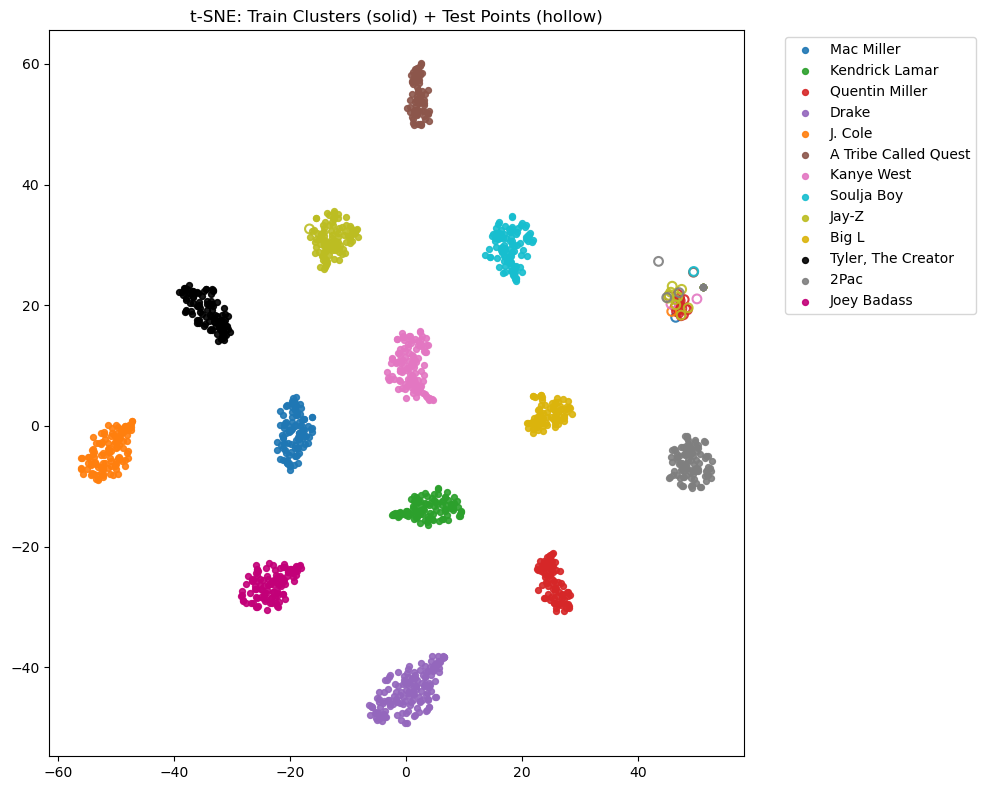

In [207]:
# get train & test logits
with torch.no_grad():
    train_logits = model(x_train).cpu().numpy()
    test_logits  = model(x_test).cpu().numpy()

train_labels = train_data['artist_id'].values
test_labels  = test_data['artist_id'].values

# combine
all_logits = np.vstack([train_logits, test_logits])

# one unified t-sne
emb_all = TSNE(n_components=2).fit_transform(all_logits)

# split back
emb_train = emb_all[:len(train_logits)]
emb_test  = emb_all[len(train_logits):]

# same artist ID → same color
artist_ids = sorted(id_to_name.keys())

colors = [
    'tab:blue','tab:green','tab:red','tab:purple','tab:orange',
    'tab:brown','tab:pink','tab:cyan','tab:olive','xkcd:gold',
    'black','tab:gray','xkcd:magenta'
]

plt.figure(figsize=(10,8))

for i, aid in enumerate(artist_ids):
    color = colors[i]
    
    # train points = solid
    tr_idx = train_labels == aid
    plt.scatter(
        emb_train[tr_idx,0], emb_train[tr_idx,1],
        color=color, s=18, alpha=0.9,
        label=id_to_name[aid] 
    )
    
    # test points = hollow circles
    te_idx = test_labels == aid
    plt.scatter(
        emb_test[te_idx,0], emb_test[te_idx,1],
        facecolors='none', edgecolors=color, s=40, linewidth=1.5, alpha=0.9
    )
    
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("t-SNE: Train Clusters (solid) + Test Points (hollow)")
plt.tight_layout()
plt.show()
